# Pytorch Custom Datasets


### 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.3.1+cu121'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 1. Get Data
- Our dataset is a subset of the Food101 dataset.
- Food101 starts with 101 different categories of food and 1000 images per class ( 750 training, 250 each testing)
- Our dataset starts with 3 classes of food and only 10% of the images (~75% training, 25 testing each)
- Why do this?
- When starting with ML project, it's important to try things on small scale and then increase the scale when necessary.
- The whole point is to speed up how fast you can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to the data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if the image folder doesn't exist , download it and perpare it
if image_path.is_dir():
    print(f"{image_path} directory already exists ..... skipping download")
else:
    image_path.mkdir(parents=True, exist_ok=True)

# Download the data
with open(data_path / "pizza_steak_sushi.zip", "wb")as f:
    #### Always copy the raw file from the github
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading.....")
    f.write(request.content)

# unzip the zip file downloaded
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unziping the dataset.......")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists ..... skipping download
Downloading.....
Unziping the dataset.......


### 2. Becoming one with the data ( data preparation and data exploration )

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data\pizza_steak_sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\test.
There are 0 directories and 25 images in data\pizza_steak_sushi\test\pizza.
There are 0 directories and 19 images in data\pizza_steak_sushi\test\steak.
There are 0 directories and 31 images in data\pizza_steak_sushi\test\sushi.
There are 3 directories and 0 images in data\pizza_steak_sushi\train.
There are 0 directories and 78 images in data\pizza_steak_sushi\train\pizza.
There are 0 directories and 75 images in data\pizza_steak_sushi\train\steak.
There are 0 directories and 72 images in data\pizza_steak_sushi\train\sushi.


In [6]:
# Setup training and testing paths **
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing and images

Lets write some code to:
1. Get all of the image paths
2. Pick a random image path using python's `random.choice()`
3. Get the image class name using `Pathlib.Path.parent.stem`
4. Since we are working with images, open the image using PIL library
5. We will show th image and print the data

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image Height: 408
Image Width: 512


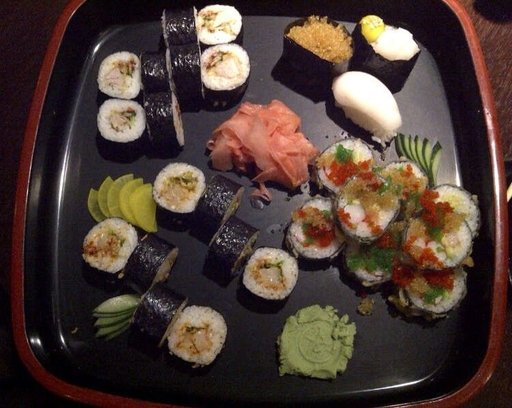

In [7]:
import random
from PIL import Image

# set Seed
random.seed(42)

# 1.  get all the image paths
image_path_lists = list(image_path.glob("*/*/*.jpg"))

# 2. Random image path and plot it
random_image_path = random.choice(image_path_lists)
#print(random_image_path)

# 3. Get the image class from the path name ( the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
#print(image_class)

# 4. Open image 
img = Image.open(random_image_path)

# 5. print Metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img


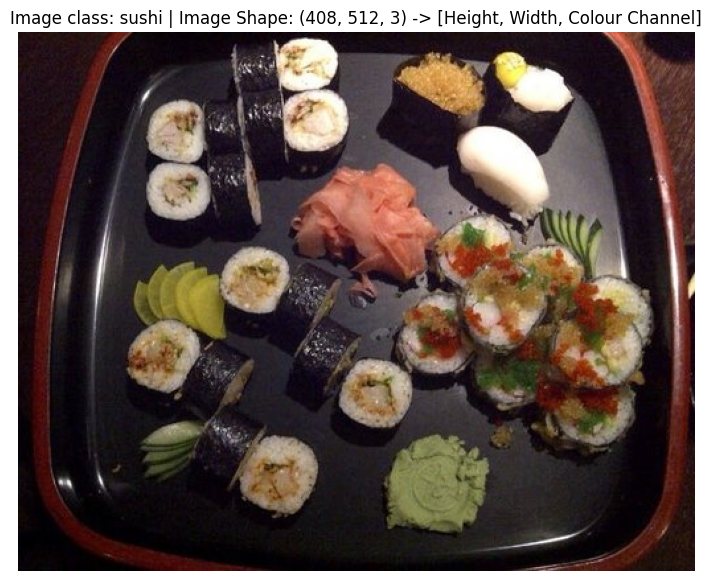

In [8]:
# try to visulaize the image with mmatplotlib library
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_as_array.shape} -> [Height, Width, Colour Channel]")
plt.axis(False);

### 3. Transforming Data
Before we can use our data with pytorch:
1. Turn your target data into tensors ( in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset`  sunsequently turned into `torch.utils.data.DataLoader`
3. 

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#### 3.1 Transforming data with torchvision.transforms
Transforms help you get your images ready to be used with a model/perform data augmentation Link: https://pytorch.org/vision/stable/transforms.html

In [10]:
# Write a transform for an image
data_transform = transforms.Compose([
    # Resize our images to 64*64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the images into a torch.Tensor
    transforms.ToTensor()
])

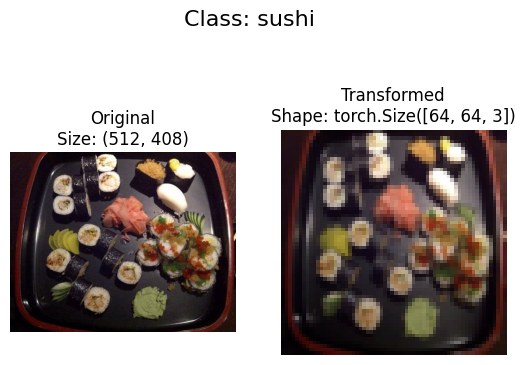

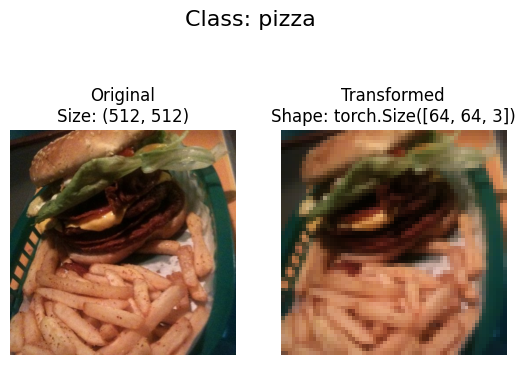

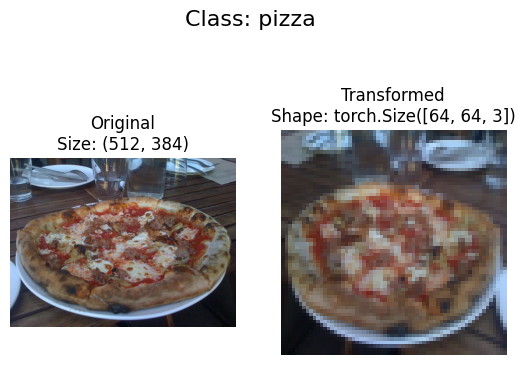

In [11]:
def plot_transformed_images(image_path, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/Transforms
    them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(42)
    random_image_path = random.sample(image_path, k=n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:    
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f) # type: ignore
            ax[0].set_title(f"Original\nSize: {f.size}") # type: ignore
            ax[0].axis(False) # type: ignore

            # TRansform and plot target image
            transformed_image = transform(f).permute(1,2,0) # changing the order from (C,H,W) -> (H,W,C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path=image_path_lists,
                        transform=data_transform,
                        n=3,
                        seed=42
                        )

#### 4.1 Option 1. Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder` : https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder


In [12]:
# Use the ImageFolder to create datasets(s)
# Pre-build datasets function developed ny Pytorch to load the data in certain structure format
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # type: ignore
                                  transform=data_transform, # A transform for the data (Custom ones)
                                  target_transform=None, # A transform for the target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform
                                 )
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict()
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the length of our datasets
len(train_data), len(test_data)

(225, 75)

In [16]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [17]:
# index on the train data Dataset to get a single image and label
img, label = train_data[0]
print(f"Image Tensor:\n {img}")
print(f"Image Shape: {img.shape}")
print(f"Image Datatype: {img.dtype}")
print(f"Image Label: {class_names[label]}")
print(f"Label Dataype: {type(label)}")

Image Tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> [Color_channels,Height,Width]
Image PErmuted shape: torch.Size([64, 64, 3]) -> [Height, Width, color_channels]


Text(0.5, 1.0, 'pizza')

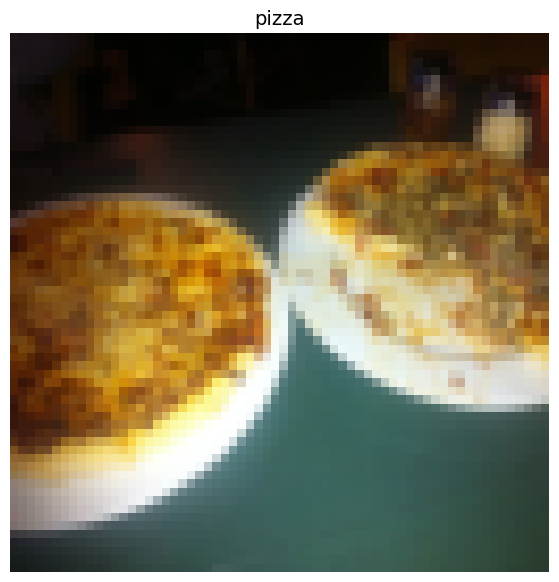

In [18]:
# Rearrage the order of dimensions
img_permute = img.permute(1,2,0)

# print out different shapes
print(f"Original Shape: {img.shape} -> [Color_channels,Height,Width]")
print(f"Image PErmuted shape: {img_permute.shape} -> [Height, Width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

#### 4.1 Turn datasets into `Dataloader`
A `Dataloader` is going to help turn our datasets into iterables and we can customize the `batch_size` so our model can see batch size at one time.

In [19]:
import os
os.cpu_count()

20

In [20]:
# Turn traina and test into dataloader
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,#os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,#os.cpu_count(),
                             shuffle=True)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [21]:
img, label = next(iter(train_dataloader))

# Batrch size will be one, you can change the batch size if you like
print(f"Image Shape: {img.shape} -> [batch_size, colour_channels, height, width]")
print(f"Label Shape: {label.shape}")

Image Shape: torch.Size([1, 3, 64, 64]) -> [batch_size, colour_channels, height, width]
Label Shape: torch.Size([1])


### 5 Option 2: Loading Image data with Custom `Dataset` instead using Pytorch nuild in functionality.
1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to pytorch pre-built `dataset` functions

Cons:
* Even though you could create `Datasets` out of almost anything, it doesnt mean it wil work.....
* Using a `Custom Dataset` often results in us writing more code, which could be prone to more errors or peformance issues.

All customs datasets in pytorch, often subclass - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
 

In [22]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [23]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names
We want a function to:
1. Get the class names using `os.scandir` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if te class names aren't found (if this happens, there might be something wrong with directort structure)
3. Turn the class names into a dict and  alist and return them.

In [24]:
# Setup Path for target directory
from matplotlib import image


target_directory = train_dir
print(f"Target Dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target Dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [25]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [26]:
# Turn the Above Steps into a executable function
def find_classes(directory: str) -> Tuple[list[str], Dict[str, int]]:
    """Finds the Class folder names in a target directory"""
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

    # 2. Raise an error if class names not to be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.... Please Check!!!")
    
    # 3. Create a dictionary of index labels ( comapre prefer numbers rather than strings as labels )
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

#### 5.2 Create a custom `Dataset` to replicate `ImageFolder` functionality
* To create our Own dataset, we ewant to:
1. subclass `torch.utils.data.Dataset`
2. Init our subclass with a target dicrectory ( the directory we would like to get data from ) as well as a transform if we would like to transform our data
3. Create several attributes:
* paths - paths of out images
* transform - the transform we would like to perform
* classes - a list to get the target classes
* class_to_idx - a dict of the target classes mapped to integer labels
4. create a function to `load_images()`, this function will open images
5. Overwrite `__len()__` method to return the length of our dataset
Overwrite the `__getitem()__` method to returhn a given sample when passed an index

In [46]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, 
                targ_dir: str,
               transform=None):
        # 3. Create class attributes
        # Get all the images paths here
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transforms
        self.transform = transform
        # Create classes adn class_to_idx
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_images(self, index: int) -> Image.Image:
        """Opens an image via path and returns it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len()__
    def __len__(self) -> int:
        """Returns the total number of samples"""
        return len(self.paths)
    
    # 6. Overwrite __getitem()__ method to return a sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, and the data label (X,y)"""
        img = self.load_images(index)
        class_name = self.paths[index].parent.name # Expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # Return data and lable index
        else:
            return img, class_idx # type: ignore # return untransformed image and label index

In [47]:
# test our custom dataset function
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])


In [48]:
# Test our custom ImageFolderCustom
train_data_custom = ImageFolderCustom(
    targ_dir=train_dir,
    transform=train_transforms
)

test_data_custom = ImageFolderCustom(
    targ_dir=test_dir,
    transform=test_transforms
)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x26a773287c0>,
 <__main__.ImageFolderCustom at 0x26a77328af0>)

In [49]:
# The original one
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [50]:
len(train_data), len(train_data_custom)

(225, 225)

In [51]:
len(test_data), len(test_data_custom)


(75, 75)

In [33]:
# Check for equality between original imageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


#### 5.3 Create a function to display random images

1. Taken in `Dataset` and number of other paramerters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, lets cap the number of images to see at 10.
3. Set the random seed for reproducibility.
4. Get a lsit of random sample indexes from the target dataset.
5. Setup a matlplotlib plot.
6. Loop through the random sample images and plot them with matpotlib.
7. Make sure the dimensions of our images line up with matplotlib.

In [34]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset, # type: ignore
                          classes: List[str]=None, # type: ignore
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None): # type: ignore
    # 2. Adjust if n is very high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For Display, Purpose, n shouldn't be larger than 10, setting to 10 and removing the display")
    
    # 3. Set the seed
    if seed:
        random.seed(seed)

    # 4. Get the random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup Matplotlib plot
    plt.figure(figsize=(16,8))

    # 6. Loop through random indexes and plot them with matplotlib
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # Changing [C,H,W] -> [H,W,C]

        # Plot the adjusted Image
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape: {targ_image_adjust.shape}"
        plt.title(title)

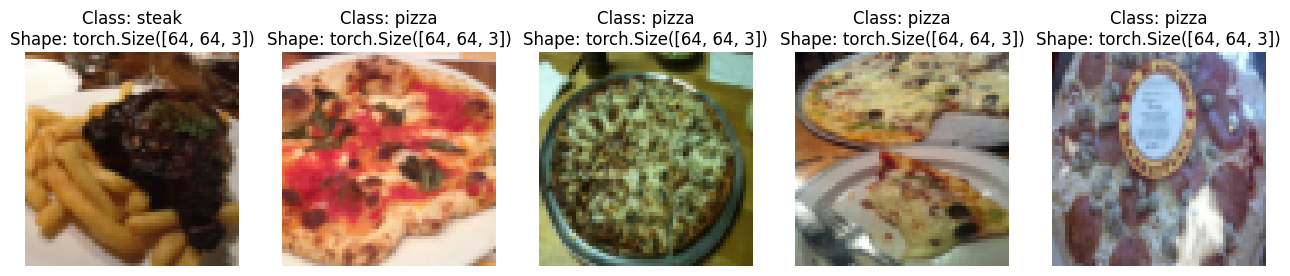

In [52]:
# Display random images fromt the ImageFolder created in ImageFolder
display_random_images(dataset=train_data,
                      n=5,
                      classes = class_names,
                      seed=None)

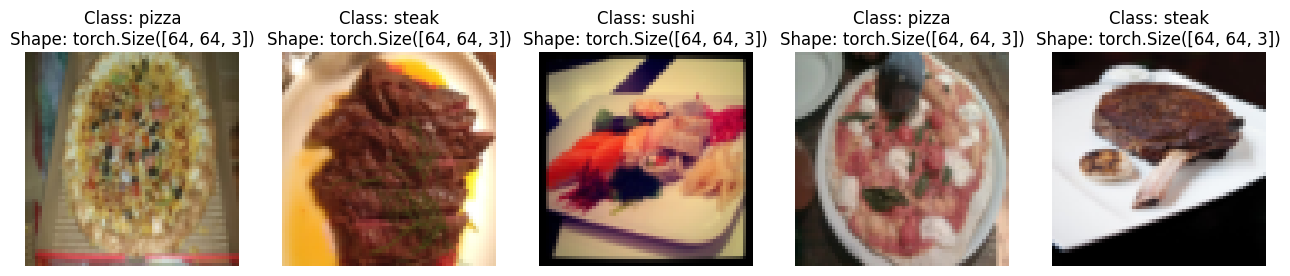

In [53]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(dataset=train_data_custom,
                      n=5,
                      classes=class_names,
                      )

#### 5.4 Turn custom Loaded images into DataLoaders

In [54]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUMBER_WORKERS = 0  # os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUMBER_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUMBER_WORKERS,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x26a776c4c70>,
 <torch.utils.data.dataloader.DataLoader at 0x26a776c55a0>)

In [55]:
# Get Image adn label from custom Dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6 Other forms of transforms ( Data Augmentation )
* Data augmentation is the process of artificially addign diversity to your trainign data.
* In this case of image data, this may mean applying various image transformation to the trainig images.
* Lets take a look at one aprticular type of data augmentation used to train PyTorch vision models to state of the art levels....
* this practise enables model to generalize more on the unseeen data
* blog post: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
* Augmentations : https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html#sphx-glr-auto-examples-transforms-plot-transforms-illustrations-py

In [56]:
# lets look at Trivial Augment -> https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html#torchvision.transforms.TrivialAugmentWide

from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])



In [57]:
image_path

WindowsPath('data/pizza_steak_sushi')

In [58]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

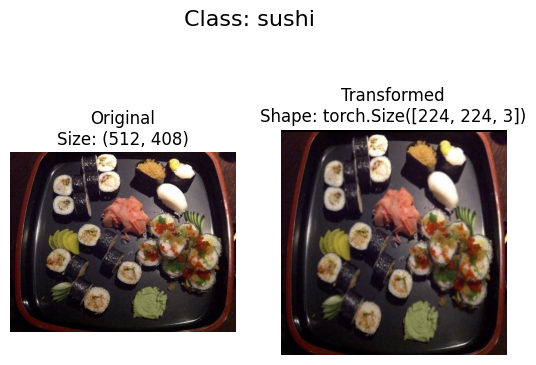

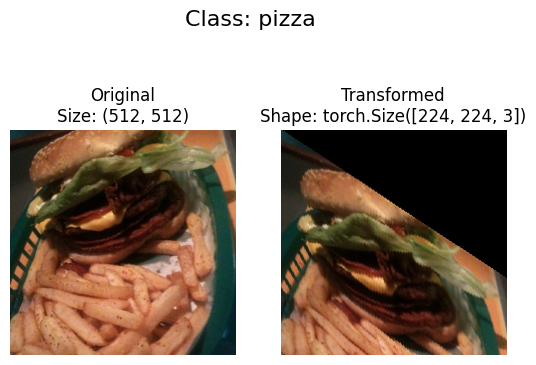

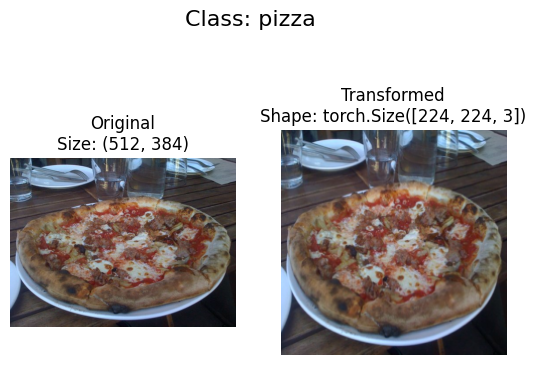

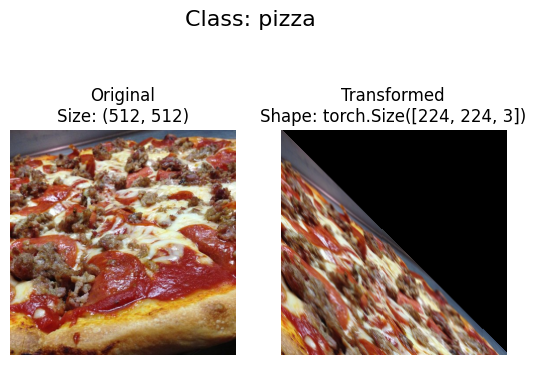

In [59]:
# Plot random transformed images
plot_transformed_images(image_path=image_path_list,
                        transform=train_transform,
                        n=4,
                        seed=42)